# NYC Taxi Fare Prediction

## Setup

In [553]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import swifter
import folium
from string import ascii_uppercase

## Inspection

In [554]:
taxi = pd.read_csv('train_prev.csv')        # Truncated preview
# taxi = pd.read_csv('train.csv', nrows=1000000)
taxi.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


In [555]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [556]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


## Cleaning

### Pickup Datetime

In [557]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'], infer_datetime_format=True)
taxi.info()

C:\Users\Alex\AppData\Local\Temp\ipykernel_1040\1128376764.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'], infer_datetime_format=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### NaN Values

In [558]:
taxi.dropna(subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### Fare Amount

<Axes: xlabel='fare_amount'>

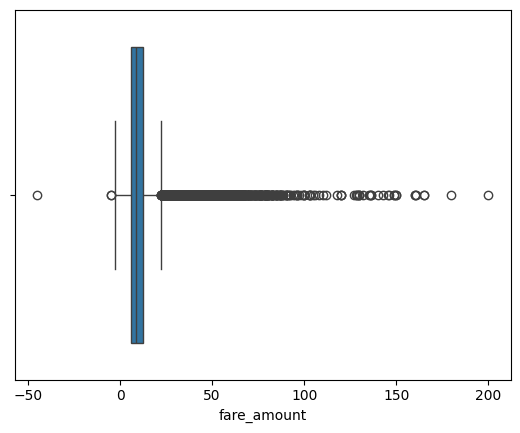

In [559]:
sns.boxplot(data=taxi, x='fare_amount')

In [560]:
# len(taxi.loc[~taxi['fare_amount'].between(0, 200)])
taxi = taxi.loc[taxi['fare_amount'].between(0, 200)]
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99991 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                99991 non-null  object             
 1   fare_amount        99991 non-null  float64            
 2   pickup_datetime    99991 non-null  datetime64[ns, UTC]
 3   pickup_longitude   99991 non-null  float64            
 4   pickup_latitude    99991 non-null  float64            
 5   dropoff_longitude  99991 non-null  float64            
 6   dropoff_latitude   99991 non-null  float64            
 7   passenger_count    99991 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.9+ MB


### Pickup Longitude

<Axes: xlabel='pickup_longitude'>

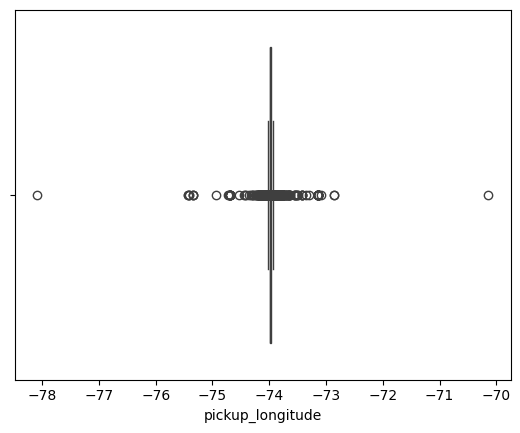

In [561]:
sns.boxplot(data=taxi.loc[taxi['pickup_longitude'].between(-80, -70)], x='pickup_longitude')

In [562]:
# len(taxi.loc[~taxi['pickup_longitude'].between(-74.5, -73.2)])
taxi = taxi.loc[taxi['pickup_longitude'].between(-74.5, -73.2)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97944.000000,97944.000000,97944.000000,97944.000000,97944.000000,97944.000000
mean,11.342689,-73.975327,40.754057,-73.910332,40.724703,1.674406
std,9.682259,0.035465,1.168396,2.169247,1.609781,1.300538
min,0.000000,-74.438233,0.783332,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992265,40.736635,-73.991387,40.735681,1.000000
50%,8.500000,-73.982077,40.753523,-73.980425,40.753934,1.000000
75%,12.500000,-73.968308,40.767655,-73.965067,40.768463,2.000000
max,200.000000,-73.307595,401.083332,0.000000,404.616667,6.000000


### Pickup Latitude

<Axes: xlabel='pickup_latitude'>

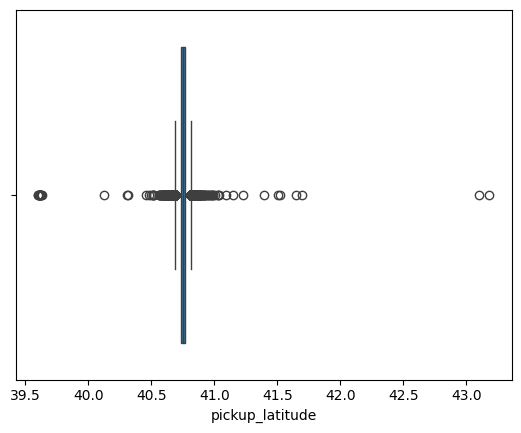

In [563]:
sns.boxplot(data=taxi.loc[taxi['pickup_latitude'].between(30, 50)], x='pickup_latitude')

In [564]:
# len(taxi.loc[~taxi['pickup_latitude'].between(40, 41.5)])
taxi = taxi.loc[taxi['pickup_latitude'].between(40, 41.5)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97921.000000,97921.000000,97921.000000,97921.000000,97921.000000,97921.000000
mean,11.343356,-73.975325,40.750936,-73.910324,40.724688,1.674462
std,9.683106,0.035422,0.027491,2.169500,1.609925,1.300538
min,0.000000,-74.438233,40.121653,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992265,40.736652,-73.991387,40.735677,1.000000
50%,8.500000,-73.982077,40.753524,-73.980426,40.753933,1.000000
75%,12.500000,-73.968317,40.767655,-73.965078,40.768458,2.000000
max,200.000000,-73.307595,41.391042,0.000000,404.616667,6.000000


### Dropoff Longitude

<Axes: xlabel='dropoff_longitude'>

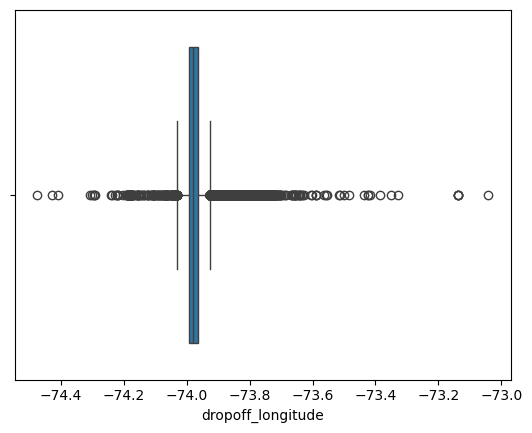

In [565]:
sns.boxplot(data=taxi.loc[taxi['dropoff_longitude'].between(-80, -70)], x='dropoff_longitude')

In [566]:
# len(taxi.loc[~taxi['dropoff_longitude'].between(-74.5, -73.2)])
taxi = taxi.loc[taxi['dropoff_longitude'].between(-74.5, -73.2)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97830.000000,97830.000000,97830.000000,97830.000000,97830.000000,97830.000000
mean,11.342409,-73.975333,40.750942,-73.974175,40.754669,1.674445
std,9.677959,0.035405,0.027485,0.035371,1.170799,1.300391
min,0.000000,-74.438233,40.121653,-74.474595,0.728087,0.000000
25%,6.000000,-73.992266,40.736652,-73.991397,40.735753,1.000000
50%,8.500000,-73.982082,40.753526,-73.980440,40.753957,1.000000
75%,12.500000,-73.968320,40.767659,-73.965148,40.768474,2.000000
max,200.000000,-73.307595,41.391042,-73.329048,404.616667,6.000000


### Dropoff Latitude

<Axes: xlabel='dropoff_latitude'>

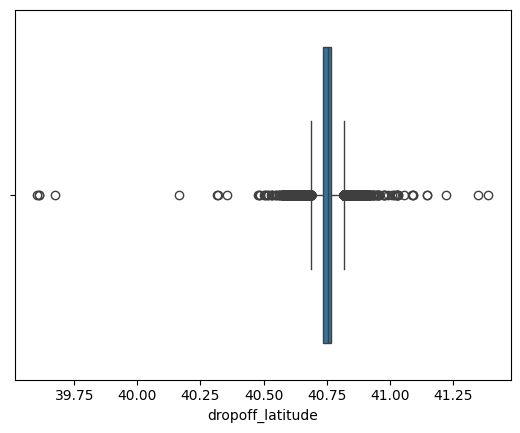

In [567]:
sns.boxplot(data=taxi.loc[taxi['dropoff_latitude'].between(30, 50)], x='dropoff_latitude')

In [568]:
# len(taxi.loc[~taxi['dropoff_latitude'].between(40, 41.5)])
taxi = taxi.loc[taxi['dropoff_latitude'].between(40, 41.5)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97824.000000,97824.000000,97824.000000,97824.000000,97824.000000,97824.000000
mean,11.342256,-73.975332,40.750943,-73.974175,40.751405,1.674456
std,9.678000,0.035406,0.027485,0.035371,0.031531,1.300416
min,0.000000,-74.438233,40.121653,-74.474595,40.164927,0.000000
25%,6.000000,-73.992266,40.736652,-73.991398,40.735762,1.000000
50%,8.500000,-73.982081,40.753526,-73.980441,40.753957,1.000000
75%,12.500000,-73.968320,40.767659,-73.965148,40.768474,2.000000
max,200.000000,-73.307595,41.391042,-73.329048,41.391042,6.000000


### Exact Same Pickup and Dropoff

In [569]:
taxi = taxi.loc[~((taxi['pickup_longitude'] == taxi['dropoff_longitude']) | (taxi['pickup_latitude'] == taxi['dropoff_latitude']))]

In [570]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96733 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                96733 non-null  object             
 1   fare_amount        96733 non-null  float64            
 2   pickup_datetime    96733 non-null  datetime64[ns, UTC]
 3   pickup_longitude   96733 non-null  float64            
 4   pickup_latitude    96733 non-null  float64            
 5   dropoff_longitude  96733 non-null  float64            
 6   dropoff_latitude   96733 non-null  float64            
 7   passenger_count    96733 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.6+ MB


### Passenger Count

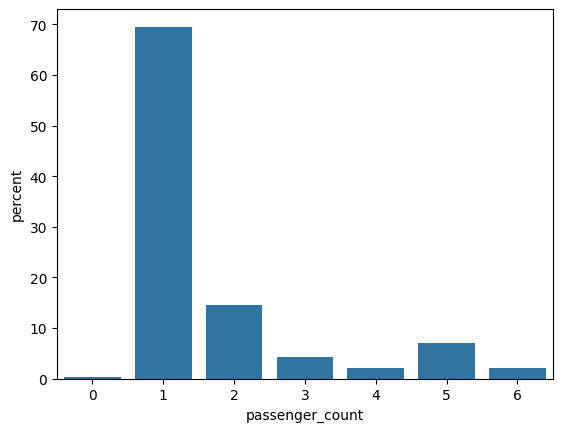

In [571]:
passenger_plt = sns.countplot(data=taxi, x='passenger_count', stat='percent')

In [572]:
# len(taxi.loc[taxi['passenger_count'] == 0])
taxi = taxi.loc[taxi['passenger_count'] != 0]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,96376.000000,96376.000000,96376.000000,96376.000000,96376.000000,96376.000000
mean,11.344653,-73.975496,40.750970,-73.974338,40.751439,1.681020
std,9.552942,0.034872,0.027144,0.034822,0.031264,1.299043
min,0.000000,-74.438233,40.121653,-74.474595,40.164927,1.000000
25%,6.000000,-73.992285,40.736683,-73.991407,40.735778,1.000000
50%,8.500000,-73.982103,40.753538,-73.980465,40.753980,1.000000
75%,12.500000,-73.968448,40.767668,-73.965331,40.768482,2.000000
max,165.000000,-73.307595,41.150487,-73.329048,41.349023,6.000000


###

In [573]:
taxi.reset_index(drop=True, inplace=True)

In [574]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96376 entries, 0 to 96375
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                96376 non-null  object             
 1   fare_amount        96376 non-null  float64            
 2   pickup_datetime    96376 non-null  datetime64[ns, UTC]
 3   pickup_longitude   96376 non-null  float64            
 4   pickup_latitude    96376 non-null  float64            
 5   dropoff_longitude  96376 non-null  float64            
 6   dropoff_latitude   96376 non-null  float64            
 7   passenger_count    96376 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 5.9+ MB


## Feature Engineering

### Distance

In [575]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6371 * c
    return km

taxi['distance_km'] = haversine(taxi['pickup_latitude'], taxi['pickup_longitude'], taxi['dropoff_latitude'], taxi['dropoff_longitude'])

In [576]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96376 entries, 0 to 96375
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                96376 non-null  object             
 1   fare_amount        96376 non-null  float64            
 2   pickup_datetime    96376 non-null  datetime64[ns, UTC]
 3   pickup_longitude   96376 non-null  float64            
 4   pickup_latitude    96376 non-null  float64            
 5   dropoff_longitude  96376 non-null  float64            
 6   dropoff_latitude   96376 non-null  float64            
 7   passenger_count    96376 non-null  int64              
 8   distance_km        96376 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(1)
memory usage: 6.6+ MB


### Time

In [577]:
taxi['pickup_hr'] = taxi['pickup_datetime'].dt.hour
taxi['pickup_dayofweek'] = taxi['pickup_datetime'].dt.dayofweek
taxi['pickup_dayofweek'].replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun', }, inplace=True)
taxi['pickup_month'] = taxi['pickup_datetime'].dt.month
taxi['pickup_year'] = taxi['pickup_datetime'].dt.year

taxi['pickup_nighttime'] = (taxi['pickup_hr'] >= 20) | (taxi['pickup_hr'] <= 5)

In [578]:
taxi.head(20)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hr,pickup_dayofweek,pickup_month,pickup_year,pickup_nighttime
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,17,Mon,6,2009,False
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,16,Tue,1,2010,False
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,0,Thu,8,2011,True
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,4,Sat,4,2012,True
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,7,Tue,3,2010,False
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1,3.787239,9,Thu,1,2011,False
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00+00:00,-73.980002,40.751662,-73.973802,40.764842,1,1.555807,20,Tue,11,2012,True
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00+00:00,-73.951300,40.774138,-73.990095,40.751048,1,4.155444,17,Wed,1,2012,False
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1,1.253232,13,Mon,12,2012,False
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00+00:00,-73.980658,40.733873,-73.991540,40.758138,2,2.849627,1,Wed,9,2009,True


### Passengers

In [579]:
taxi['multiple_passengers'] = np.where(taxi['passenger_count'] > 1, True, False)

### Location

In [580]:
clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(ascii_uppercase)}

pickup_locs = taxi[['pickup_longitude', 'pickup_latitude']]

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(pickup_locs)

taxi['pickup_loc'] = pd.Series(kmeans.labels_).replace(clust_name_dict)

In [581]:
dropoff_locs = taxi[['dropoff_longitude', 'dropoff_latitude']]

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(dropoff_locs)

taxi['dropoff_loc'] = pd.Series(kmeans.labels_).replace(clust_name_dict)

In [582]:
distance_locs = taxi[['distance_km', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(distance_locs)

taxi['distance_loc'] = pd.Series(kmeans.labels_).replace(clust_name_dict)

### Airports

In [583]:
taxi['jfk'] = (taxi['pickup_longitude'].between(-73.7841, -73.7721) & taxi['pickup_latitude'].between(40.6213, 40.6613)) | (taxi['dropoff_longitude'].between(-73.7841, -73.7721) & taxi['dropoff_latitude'].between(40.6213, 40.6613))
taxi['lga'] = (taxi['pickup_longitude'].between(-73.8870, -73.8580) & taxi['pickup_latitude'].between(40.7680, 40.7800)) | (taxi['dropoff_longitude'].between(-73.8870, -73.8580) & taxi['dropoff_latitude'].between(40.7680, 40.7800))
taxi['ewr'] = (taxi['pickup_longitude'].between(-74.1920, -74.1720) & taxi['pickup_latitude'].between(40.6760, 40.7080)) | (taxi['dropoff_longitude'].between(-74.1920, -74.1720) & taxi['dropoff_latitude'].between(40.6760, 40.7080))

print(taxi['fare_amount'].mean())
print(taxi.loc[taxi['jfk']]['fare_amount'].mean())
print(taxi.loc[taxi['lga']]['fare_amount'].mean())
print(taxi.loc[taxi['ewr']]['fare_amount'].mean())

11.344652818128996
45.80763551401869
30.728803797468352
68.96771653543308


In [584]:
# taxi['jfk_pu'] = taxi['pickup_longitude'].between(-73.7841, -73.7721) & taxi['pickup_latitude'].between(40.6213, 40.6613)
# taxi['jfk_do'] = taxi['dropoff_longitude'].between(-73.7841, -73.7721) & taxi['dropoff_latitude'].between(40.6213, 40.6613)

# taxi['lga_pu'] = taxi['pickup_longitude'].between(-73.8870, -73.8580) & taxi['pickup_latitude'].between(40.7680, 40.7800)
# taxi['lga_do'] = taxi['dropoff_longitude'].between(-73.8870, -73.8580) & taxi['dropoff_latitude'].between(40.7680, 40.7800)

# taxi['ewr_pu'] = taxi['pickup_longitude'].between(-74.1920, -74.1720) & taxi['pickup_latitude'].between(40.6760, 40.7080)
# taxi['ewr_do'] = taxi['dropoff_longitude'].between(-74.1920, -74.1720) & taxi['dropoff_latitude'].between(40.6760, 40.7080)

# print(taxi.loc[taxi['jfk_pu']]['fare_amount'].mean())
# print(taxi.loc[taxi['jfk_do']]['fare_amount'].mean())
# print(taxi.loc[taxi['lga_pu']]['fare_amount'].mean())
# print(taxi.loc[taxi['lga_do']]['fare_amount'].mean())
# print(taxi.loc[taxi['ewr_pu']]['fare_amount'].mean())
# print(taxi.loc[taxi['ewr_do']]['fare_amount'].mean())

In [585]:
m = folium.Map(location=(40.7, -74.0))
folium.Marker(location=(40.642, -73.779), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
folium.Marker(location=(40.776, -73.874), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
folium.Marker(location=(40.691, -74.178), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
# taxi.loc[taxi['jfk_pu']].apply(lambda r:folium.Marker(location=(r['pickup_latitude'], r['pickup_longitude'])).add_to(m), axis=1)

display(m)

## Relationships

### Fare vs Distance

<Axes: xlabel='distance_km', ylabel='fare_amount'>

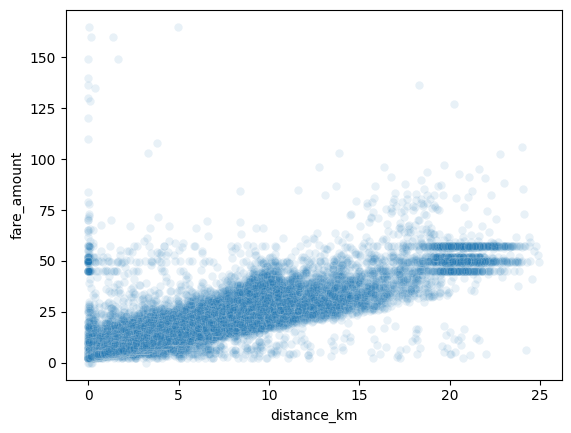

In [586]:
sns.scatterplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', alpha=0.1)

In [587]:
# sns.lmplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='passenger_count', scatter_kws={'alpha':0.1})

### Fare vs Passengers

<Axes: xlabel='passenger_count', ylabel='count'>

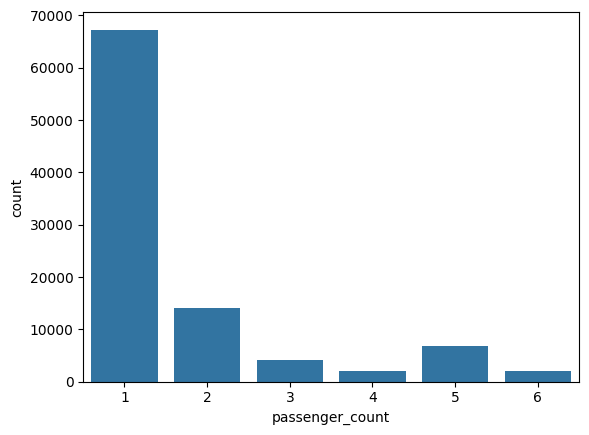

In [588]:
sns.countplot(data=taxi, x='passenger_count')

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

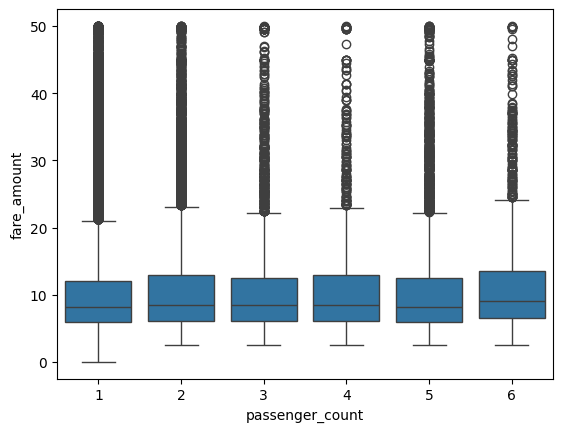

In [589]:
sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='passenger_count', y='fare_amount')

<Axes: xlabel='multiple_passengers', ylabel='fare_amount'>

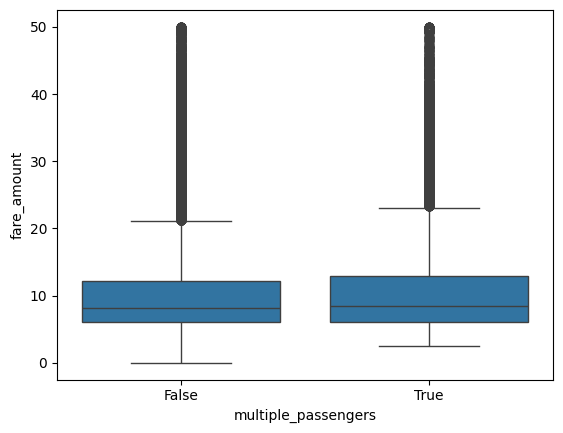

In [590]:
taxi_pass_red = taxi.copy()
taxi_pass_red['multiple_passengers'] = np.where(taxi_pass_red['passenger_count'] > 1, True, False)

sns.boxplot(data=taxi_pass_red.loc[taxi_pass_red['fare_amount'] <= 50], x='multiple_passengers', y='fare_amount')

In [591]:
# sns.lmplot(data=taxi_pass_red.loc[taxi_pass_red['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='multiple_passengers', scatter_kws={'alpha':0.02})

### Fare vs Time

#### Fare vs Pickup Hour

Text(0.5, 1.0, 'Fare vs Pickup Hour')

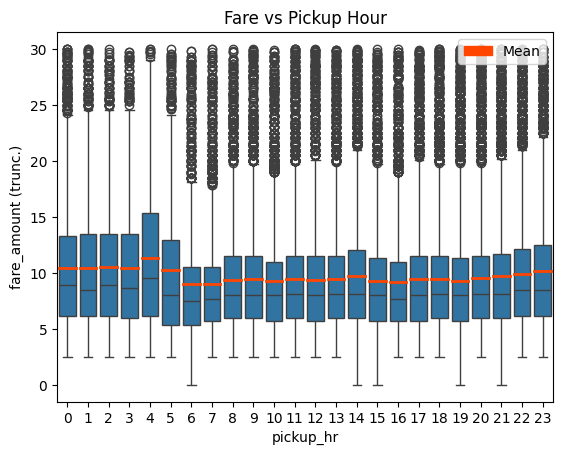

In [592]:
fare_hr_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_hr', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_hr_box.set_ylabel(f'{fare_hr_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Hour')

#### Fare vs Pickup Day of Week

Text(0.5, 1.0, 'Fare vs Pickup Day of Week')

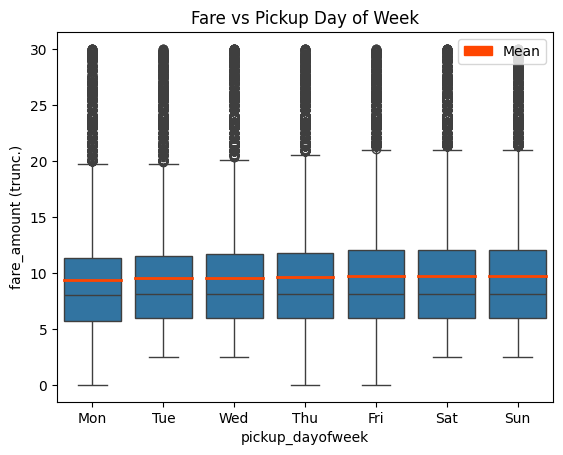

In [593]:
fare_dayofweek_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_dayofweek', y='fare_amount', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_dayofweek_box.set_ylabel(f'{fare_dayofweek_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Day of Week')

#### Fare vs Pickup Month

Text(0.5, 1.0, 'Fare vs Pickup Month')

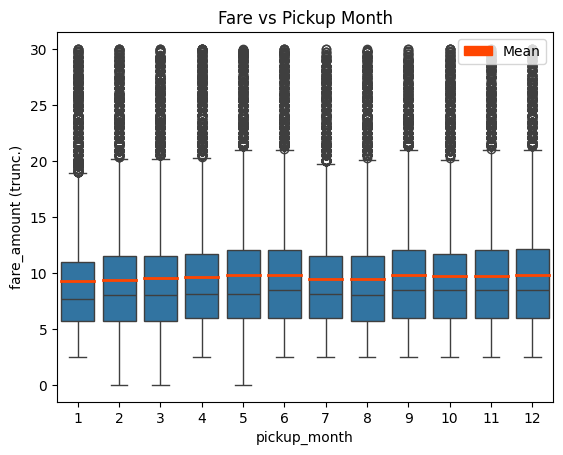

In [594]:
fare_month_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_month', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_month_box.set_ylabel(f'{fare_month_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Month')

#### Fare vs Pickup Year

Text(0.5, 1.0, 'Fare vs Pickup Year')

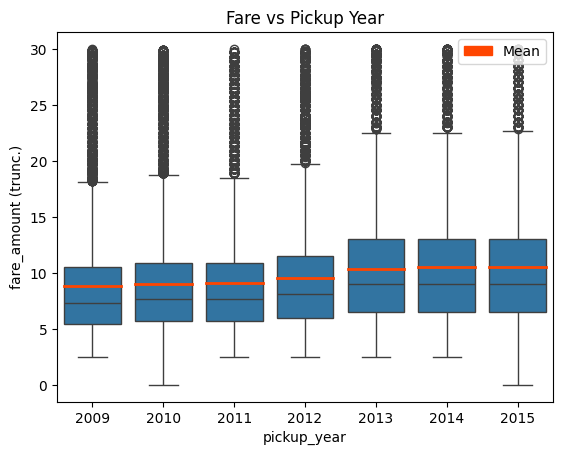

In [595]:
fare_year_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_year', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_year_box.set_ylabel(f'{fare_year_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Year')

#### Fare vs Pickup Day of Week and Hour

<Axes: xlabel='pickup_dayofweek', ylabel='pickup_hr'>

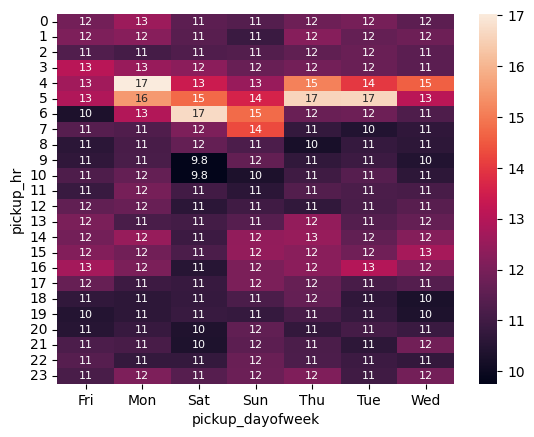

In [596]:
fare_dayofweek_hr = taxi.groupby(['pickup_dayofweek', 'pickup_hr'])['fare_amount'].mean().reset_index()
fare_dayofweek_hr = fare_dayofweek_hr.pivot(index='pickup_hr', columns='pickup_dayofweek', values='fare_amount')

sns.heatmap(data=fare_dayofweek_hr, annot=True, annot_kws={'size':8})

### Location

In [597]:
# sns.scatterplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='dropoff_longitude', y='dropoff_latitude', hue='fare_amount', alpha=0.5)

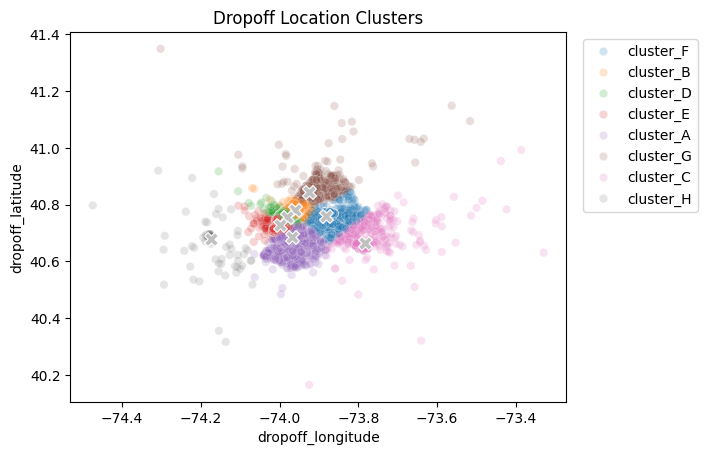

In [598]:
dropoff_locs = taxi[['dropoff_longitude', 'dropoff_latitude']]
# scaler = StandardScaler()
# scaled_dropoff_locs = scaler.fit_transform(dropoff_locs)

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(dropoff_locs)

clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(ascii_uppercase)}
kmeans_clusters = pd.Series(kmeans.labels_).replace(clust_name_dict)
kmeans_centroids = pd.DataFrame(kmeans.cluster_centers_).rename(columns={0:'dropoff_longitude', 1:'dropoff_latitude'}, index=clust_name_dict)

sns.scatterplot(data=taxi, x='dropoff_longitude', y='dropoff_latitude', hue=kmeans_clusters, alpha=0.2)
sns.scatterplot(data=kmeans_centroids, x='dropoff_longitude', y='dropoff_latitude', s=100, c='silver', marker='X')
plt.title('Dropoff Location Clusters')
plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1))

In [599]:
kmeans_cluster_fares = pd.DataFrame()
kmeans_cluster_fares['count'] = taxi.groupby(kmeans_clusters)['key'].count()
kmeans_cluster_fares['mean'] = taxi.groupby(kmeans_clusters)['fare_amount'].mean()
kmeans_cluster_fares['mean_diff'] = kmeans_cluster_fares['mean'] - taxi['fare_amount'].mean()
kmeans_cluster_fares['summed_diff'] = kmeans_cluster_fares['count'] * abs(kmeans_cluster_fares['mean_diff'])
print(kmeans_cluster_fares['summed_diff'].sum()/len(taxi))
kmeans_cluster_fares.head(100)

# ax = sns.barplot(kmeans_cluster_fares)
# ax.bar_label(ax.containers[0], fontsize=6)

2.6935842141159605


,count,mean,mean_diff,summed_diff
cluster_A,4475,18.686384,7.341732,32854.248639
cluster_B,21227,9.804861,-1.539792,32685.165370
cluster_C,1137,41.194116,29.849463,33938.839746
cluster_D,39158,9.692856,-1.651797,64681.065052
cluster_E,25633,10.079401,-1.265252,32432.205687
cluster_F,2982,23.785758,12.441105,37099.375296
cluster_G,1587,22.071651,10.726998,17023.745978
cluster_H,177,61.526723,50.182070,8882.226451


## Data Selection

In [600]:
y = taxi['fare_amount']

num_features = ['distance_km']
cat_features = ['pickup_nighttime', 'jfk', 'lga', 'ewr']
cat_ohe_features = ['pickup_year', 'pickup_loc', 'dropoff_loc', 'distance_loc']

features_list = num_features + cat_features + cat_ohe_features

X_cat = taxi[features_list]
X = pd.get_dummies(X_cat, columns=cat_ohe_features)
cat_labels = [f for f in X if f.startswith(tuple(cat_features + cat_ohe_features))]



## Modelling

In [601]:
test_size_vals = [0.1, 0.2, 0.4]
results_dict = {}

repeats = 10
aggr_RMSE_list = [0 for _ in range(repeats)]

# model = LinearRegression()
model = HistGradientBoostingRegressor(max_leaf_nodes=20, categorical_features=cat_labels)
for test_size_val in test_size_vals:
    for repeat in range(repeats):
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=test_size_val, random_state=repeat)
        model.fit(train_X, train_y)
        pred_y = model.predict(val_X)
        aggr_RMSE_list[repeat] = mean_squared_error(val_y, pred_y, squared=False)
    aggr_RMSE = (sum(aggr_RMSE_list)/repeats)
    results_dict[test_size_val] = round(aggr_RMSE, 4)

results = pd.Series(results_dict)
print(f"Mean RMSE: {results.mean():.4f}")
print(results)

Mean RMSE: 4.0033
0.1    3.9835
0.2    3.9966
0.4    4.0299
dtype: float64


In [602]:
# model = HistGradientBoostingRegressor(categorical_features=cat_labels)
# params ={'max_iter':[100, 150, 200], 'max_leaf_nodes':[31, 20, 25], 'max_depth':[None, 8, 10, 12]}
# gs_cv = GridSearchCV(model, params, verbose=1)
# gs_cv.fit(X, y)
# pd.DataFrame(gs_cv.cv_results_).sort_values(by='rank_test_score')